In [7]:
from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(H0=70,Om0=0.3) # Use standard cosmology model from astropy.

from astropy.table import Table
from scipy.stats import binned_statistic, scoreatpercentile
import scipy.stats.distributions as dist

import urllib
from PIL import Image

source_dir = '../../fits/'
data_file = 'volume_limited_sample.fits'
debiased_file = 'debiased_volume_limited_sample.fits'

#-------------------------------------------------------
import matplotlib as mpl
from prefig import Prefig
Prefig()
% matplotlib inline

from matplotlib.ticker import MaxNLocator

plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 6
mpl.ticker.AutoLocator.default_params['prune'] = 'both'
#------------------------------------------------------

% matplotlib inline

from astropy.coordinates import matching
from astropy.coordinates import SkyCoord
from astropy import units as u

In [106]:
data = fits.getdata(source_dir + data_file)
data = Table(data)
finite_select = np.isfinite(data['LOGMSTAR_BALDRY06'])
data = data[finite_select]

z = data['REDSHIFT_1']
ra = data['ra_1']
dec = data['dec_1']
# Converting redshifts to distances:
D = cosmo.luminosity_distance(z) # In Mpc

sdss_coord = SkyCoord(ra=ra*u.degree,dec=dec*u.degree,distance=D*u.Mpc) 

In [107]:
i,sep2,sep3 = matching.match_coordinates_3d(sdss_coord,sdss_coord,nthneighbor=2)
separation_distance = np.sqrt(sep3)

In [108]:
debiased = fits.getdata(source_dir + debiased_file)
debiased = Table(debiased)
debiased = debiased[finite_select]

In [97]:
# Now bin quantities by separation distance to observe the vote fractions?

def assign(table,debiased_table,th=0,redistribute=False,rd_th=0,ct_th=0,print_sizes=False,raw=False):
    
    m_columns = debiased_table.colnames
    
    if raw == True:
        m_array = np.array([table[column] for column in m_columns]).T
    else:
        m_array = np.array([debiased_table[column] for column in m_columns]).T
    
    arm_assignments = np.ones(len(table))*(-999) # Assigned arm numbers 
    # initially is an array of -999s. -999 means 'no assignment'.
    for m in range(6):
        a = (np.argmax(m_array,axis=1) == m) & (m_array[:,m] >= th)
        arm_assignments[a] = m
        
    if redistribute is True: # Redistribute according to thresholds.
        for m in range(5):
            arm_assignments[(np.argmax(m_array[:,:5],axis=1) == m) 
                & (arm_assignments == 5) & (table[:,m]/table[:,5] > rd_th) 
                & (table[:,5] <= ct_th)] = m

    if print_sizes is True:
        print("total sample: " + str(len(arm_assignments)))
        print("total 'assigned' sample: " 
              + str(np.sum(arm_assignments != -999)))
        for m in range(6):
            print("m = " + str(m+1) + ": " 
                  + str(np.sum(arm_assignments == m)))
      
    return arm_assignments

In [219]:
p_spiral = (data.field("t01_smooth_or_features_a02_features_or_disk_debiased")
        *data.field("t02_edgeon_a05_no_debiased")
        *data.field("t04_spiral_a08_spiral_debiased"))
N_spiral = (data.field("t04_spiral_a08_spiral_count")) # Load values to
    # allow data cuts to be made.
    
select_spiral = (p_spiral > 0.5) & (N_spiral >= 5)

spirals = data[select_spiral]
debiased_spirals = debiased[select_spiral]
separation_distance_spirals = separation_distance[select_spiral]
index_spirals = i[select_spiral]
assignments = assign(spirals,debiased_spirals)

In [99]:
def bin_by_column(column, nbins, fixedcount=True):
    sorted_indices = np.argsort(column)
    if fixedcount:
        bin_edges = np.linspace(0, 1, nbins + 1)
        bin_edges[-1] += 1
        values = np.empty(len(column))
        values[sorted_indices] = np.linspace(0, 1, len(column))
        bins = np.digitize(values, bins=bin_edges)
    else:
        bin_edges = np.linspace(np.min(column),np.max(column), nbins + 1)
        bin_edges[-1] += 1
        values = column
        bins = np.digitize(values, bins=bin_edges)
    x, b, n = binned_statistic(values, column, bins=bin_edges)
    return x, bins

In [100]:
def binned_morph_frac(morph, bins):
    total = np.bincount(bins)[1:]
    frac = []
    for m in np.unique(morph):
        count = np.bincount(bins[morph == m], minlength=bins.max()+1)[1:]
        frac.append(frac_errors(count, total))
    return frac

In [101]:
def plot_morph_frac_trend(x, frac, frac_raw=None, xlabel='redshift', answerlabels=None,label_position=[0.04,0.95]):
    C = ['orange','red','magenta','green','blue']
    nmorph = len(frac)
    fig, axarr = plt.subplots(5, 1, sharex=True, sharey=False, figsize=(10, 3*nmorph))
    
    for m in range(5):
        ax = axarr[m]
        ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, prune="upper"))
        if frac_raw is not None:
            ax.plot(x, frac_raw[m]['frac'], '--', color=C[m], lw=2, alpha=0.5)
            ax.fill_between(x, frac_raw[m]['low'], frac_raw[m]['high'], color=C[m], alpha=0.25)
        mean = frac[m]['frac'].mean()
        ax.hlines([mean], -100, 100, linestyle=':', color=C[m], lw=3)
        ax.plot(x, frac[m]['frac'], color=C[m], lw=2)
        ax.fill_between(x, frac[m]['low'], frac[m]['high'], color=C[m], alpha=0.5)
        
        ax.set_ylabel('fraction',fontsize=18)
        if answerlabels is not None:
            ax.text(label_position[0], label_position[1], answerlabels[m], transform=ax.transAxes, va='top',fontsize=20)
            
            ax.yaxis.set_major_locator(MaxNLocator(nbins=6,prune='both'))
    ax.set_xlabel(xlabel,fontsize=18)
    
    plt.subplots_adjust(hspace=0)

In [102]:
def frac_errors(k, n, c=0.683):
    # Gets the errors according to the Cameron et al. paper.
    
    # cope with both array and individual value inputs
    k = np.array(k, np.float, ndmin=1)
    frac = k / n
    low = dist.beta.ppf((1-c)/2., k+1, n-k+1)
    high = dist.beta.ppf(1-(1-c)/2., k+1, n-k+1)    
    # ensure confidence intervals are sensible for
    # extreme fractions
    low = np.where(frac < low, 0.0, low)
    high = np.where(frac > high, 1.0, high)
    # return sensible shaped arrays
    out = Table((frac, low, high), names=('frac', 'low', 'high'))
    return out

(0.4, 3.5)

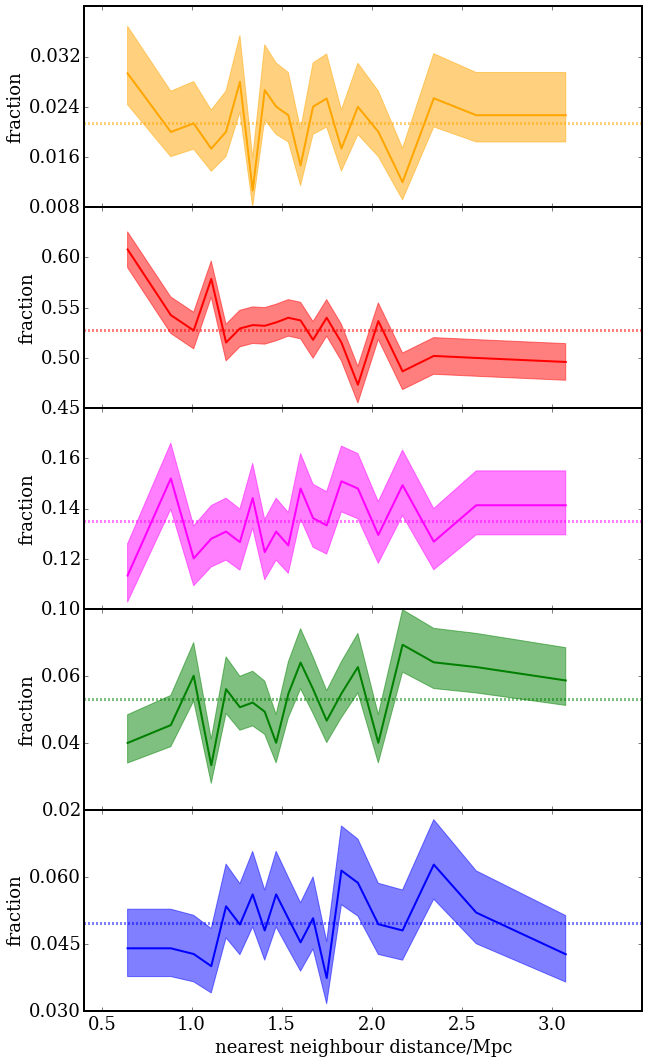

In [103]:
bin_values,bin_assignments = bin_by_column(separation_distance_spirals,20,fixedcount=True)
frac = binned_morph_frac(assignments,bin_assignments)

plot_morph_frac_trend(bin_values,frac,xlabel='nearest neighbour distance/Mpc')

plt.xlim(0.4,3.5)

In [104]:
def display_image(url_name,crop_in=100):
    # Get the url name:
    urllib.request.urlretrieve(url_name,"image.jpg")
    # Open -> crop -> display -> remove the image.
    im=Image.open("image.jpg")
    l=424 # Image size
    im=im.crop((crop_in,crop_in,l-crop_in,l-crop_in))
    plt.imshow(im)
    os.remove("image.jpg")
    plt.xticks([])
    plt.yticks([])
    return None

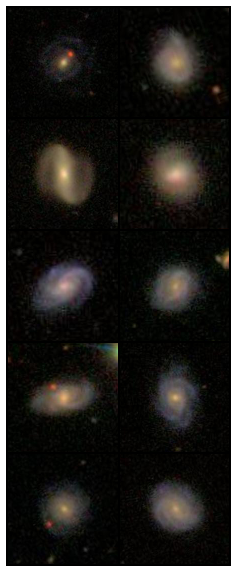

In [105]:
# Look at images of near/far separated galaxies?
random.seed(0)

close = bin_assignments == np.min(np.unique(bin_assignments))
far = bin_assignments == np.max(np.unique(bin_assignments))

fig,axes = plt.subplots(5,2,figsize=(4,10))
plt.subplots_adjust(hspace=0,wspace=0)

for m in range(5):
    
    select = (assignments == m) & (close == True)
    urls = spirals[select]
    
    if np.sum(select) > 0:
        url = random.choice(urls['jpeg_url'])
        plt.sca(axes[m,0])
        display_image(url)
    
    select = (assignments == m) & (far == True)
    urls = spirals[select]
    
    if np.sum(select) > 0:
        url = random.choice(urls['jpeg_url'])
        plt.sca(axes[m,1])
        display_image(url)

In [211]:
# 2 armed distributions:

lims = [[-2,2],[-1,1]]
nb = 25

H2,X2,Y2 = np.histogram2d(np.log10(mass_ratios[assignments == 1]),np.log10(sep_d[assignments == 1])
                     ,range=lims,bins=nb)
H,X,Y = np.histogram2d(np.log10(mass_ratios),np.log10(sep_d)
                     ,range=lims,bins=nb)

f_2 = H2/H

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide


In [212]:
# Get neighbour ratios?

mass_ratios = 10**(data['LOGMSTAR_BALDRY06']-data[i]['LOGMSTAR_BALDRY06'])[select_spiral]
sep_d = np.array(separation_distance)[select_spiral]

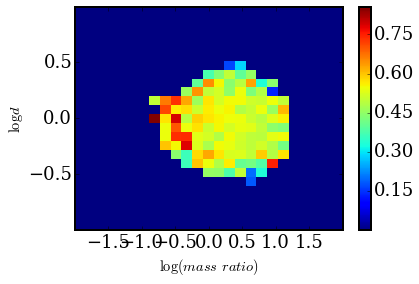

In [213]:
f_2[np.isfinite(f_2) == 0] = 0
f_2[H <= 5] = 0

plt.pcolormesh(X,Y,f_2)
plt.colorbar()

plt.xlabel(r'$\log(mass \, ratio)$')
plt.ylabel(r'$\logd$')

# This plot is pretty terrible.

In [247]:
def plot_by_bins(column,bin_edges,xlabel='Nearest neighbour/Mpc',linelabels='M'):
    
    for Mb in range(len(bin_edges)-1):
    
        select = ((column >= bin_edges[Mb]) 
                       & (column < bin_edges[Mb+1]))
    
        spirals_mass = spirals[select]
        debiased_mass = debiased[select]
        m_vals_mass = assignments[select]
        sep_d_mass = sep_d[select]
    
        bin_values,bin_assignments = bin_by_column(sep_d_mass,10,fixedcount=True)
        frac_2 = np.zeros(len(np.unique(bin_assignments)))
    
        for b in enumerate(np.unique(bin_assignments)):
            m_vals_b = m_vals_mass[bin_assignments == b[1]]
            frac_2[b[0]] = np.sum(m_vals_b == 1)/len(m_vals_b)

        plt.plot(bin_values,frac_2,label='{} < {} < {}'.format(mass_bin_edges[Mb],linelabels,mass_bin_edges[Mb+1]))
        plt.xlabel(xlabel)
        plt.ylabel('$f_2$')
        plt.legend()
    
    return None

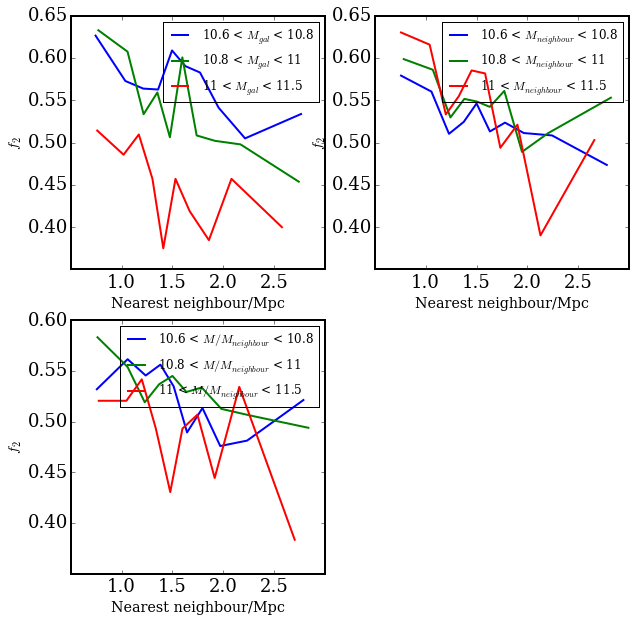

In [253]:
# Bin by galaxy mass and then plot different lines of 2 arm vote fractions with nearest neighbour distance.
# Only complete above >10.6M_sun

fig,axes = plt.subplots(2,2,figsize=(10,10))
axes = axes.ravel()

fig.delaxes(axes[-1])

plt.sca(axes[0])
mass_bin_edges = [10.6,10.8,11,11.5]
plot_by_bins(spirals['LOGMSTAR_BALDRY06'],mass_bin_edges,linelabels='$M_{gal}$')

plt.sca(axes[1])
plot_by_bins(data[index_spirals]['LOGMSTAR_BALDRY06'],mass_bin_edges,linelabels='$M_{neighbour}$')

plt.sca(axes[2])
ratio_bin_edges = [0.1,0.33,3,10]
plot_by_bins(mass_ratios,ratio_bin_edges,linelabels='$M/M_{neighbour}$')